#Dataset creation:
it requires a excel file with lat and long of the point locations

creates stellargraph instances

In [ ]:
!pip install osmnx
!pip install --upgrade xlrd

In [ ]:
import osmnx as ox
import matplotlib
import networkx as nx
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import shapely
import geopandas as gpd
import itertools

In [ ]:
url="https://docs.google.com/spreadsheets/d/1iASclM8Hwaro9TQEa2AnBs6fDo2_AQgp/edit?usp=sharing&ouid=108747149587154465757&rtpof=true&sd=true"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

In [ ]:
geocodes_dataframe=pd.read_excel(url, engine = 'openpyxl')
geocodes_dataframe

,Geocode,Location
0,"Via Pietro Secondo Orseolo, Grado, Gorizia, Fr...","45.6772, 13.3863"
1,"Viale delle Terme, Lignano Pineta, Lignano Sab...","45.6636, 13.1045"
2,"Viale Aurora, Bibione, San Michele al Tagliame...","45.6354, 13.0483"
3,"Sottomarina, Chioggia, Venezia, Veneto, 30015,...","45.2026, 12.2928"
4,"Parco della Rimembranza, Cervia, Ravenna, Emil...","44.2606, 12.3517"
...,...,...
105,"Borgo Castello, Loano, Savona, Liguria, 17025,...","44.1257, 8.2515"
106,"Colla Micheri, Andora, Savona, Liguria, 17053,...","43.9547, 8.1464"
107,"Diano Calderina, Imperia, Liguria, 18013, Italy","43.9122, 8.08"
108,"Galleria Francia, Sanremo, Imperia, Liguria, 1...","43.8185, 7.7735"


In [ ]:
cities =[i for i in geocodes_dataframe.Location] 

cities =[tuple(map(float, i.split(', '))) for i in cities] 
type(cities)

list

## Saving city plots

In [ ]:
index = 42

for city in cities[41:]:
  G = ox.graph_from_point(city, dist=800, network_type='drive', simplify=False)
  ox.plot_graph(G, ax = None, figsize=(5,5),bgcolor='white', show=True,node_size=0, edge_linewidth=2, edge_color="#000000", save=True, 
                filepath="/content/drive/MyDrive/THESIS - SNG/01. DATASET/coastal cities plots/{}.png".format(index), 
                dpi = 100)
  index+=1

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

def load_images_from_folder(folder):
    images = []
    filenames = glob.glob(os.path.join(folder,"*"))
    for i in range(0,len(filenames)):
      img = cv2.imread(os.path.join(folder,'{}.png'.format(i)))
      if img is not None:
        #img = cv2.resize(img, (150, 150))   
        images.append(img)
    return images

##Create dataset

In [ ]:
from statistics import mean

In [ ]:
#instantiate empty list to which Stellar graph instances will be appended
graphs =[]
graphnr =1

for city in cities:
  G = ox.graph_from_point(city, dist=300, network_type='drive', simplify=True)
  G = ox.utils_graph.get_undirected(G)

  ox.bearing.add_edge_bearings(G, precision=1)

  nodes, edges = ox.utils_graph.graph_to_gdfs(G)

  nodes["avg_angle"] = " "
  nodes["max_angle"] = " "
  nodes["min_angle"] = " "
  nodes["prop_angle"] = " "
  nodes["prop_length"] = " "

  for index in nodes.index:
  # nodes with street count >2 are dead ends, we dont give attributes to them
    if nodes.at[index,'street_count']>=2:
      index = int(index)
      #get the lengths of the edges the node is either a startpoint or an endpoint
      dl = edges.query('u == {}'.format(index)).length
      dl=dl.append(edges.query('v == {}'.format(index)).length)
      #convert the created dataframe to a list
      length = dl.tolist()
      #assign the feature to the respective node column
      if min(length)!=0:
        nodes.at[index,'prop_length'] = round(max(length)/min(length),2)
      #get the calculated bearing of the edges the node is either a startpoint or an endpoint
      
      #for calculating the angles between intersecting streets we use the calculated bearing in osmnx
      #bearing is the angle between the geodesic north and the edge
      df1 = edges.query('u == {}'.format(index)).bearing
      df2 = edges.query('v == {}'.format(index)).bearing
      
      #angle is max-min angle of the 2 edges, note that when the node is v of the edge we need to add 180 degrees to the bearing
      #thats why we divide them in 2 lists
      ang_u= df1.tolist()

      ang_v= df2.tolist()
      ang_v =[x+180 for x in ang_v]

      angles = ang_u+ang_v

      if len(angles)>1:
        #create pairs of the streets in the intersection
        street_pairs = list(itertools.combinations(angles, 2))
        int_angles =[]
        for streets in street_pairs:
          int_angles.append(max(streets)-min(streets))
        int_angles = [x for x in int_angles if math.isnan(x) == False]

        if len(int_angles)>0:
          nodes.at[index,'avg_angle'] = int(mean(int_angles))
          nodes.at[index,'max_angle'] = int(max(int_angles))
          nodes.at[index,'min_angle'] = int(min(int_angles))
          if int(min(int_angles))==0:
            continue
          else:
            nodes.at[index,'prop_angle'] = round(int(max(int_angles))/int(min(int_angles)),2)

  nodes = pd.DataFrame().assign(street_count=nodes['street_count'], avg_angle=nodes['avg_angle'], max_angle=nodes['max_angle'],min_angle=nodes['min_angle'],prop_angle=nodes['prop_angle'],prop_length=nodes['prop_length'])
  nodes=nodes.replace(' ', 0) 

  edges = edges.reset_index()
  edges = pd.DataFrame().assign(source=edges['from'], target=edges['to'], weight=edges['length'])
  edges=edges.replace(' ', 0) 

  citygraph = StellarGraph(nodes, edges)
  graphs.append(citygraph)

  print('graph number                    == {}'.format(graphnr))
  graphnr+=1

In [ ]:
import pickle
# Dump graph
with open("/content/drive/MyDrive/THESIS - SNG/01. DATASET/stellargraphs/graphs 300 m/stellargraphs_100simplified.p", 'wb') as f:
    pickle.dump(graphs, f)

# START FROM HERE

#Install Stellargraph library

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph import StellarGraph

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import networkx as nx
import math

from IPython.display import display, HTML

#Load dataset

In [ ]:
import pickle
# Load graph
with open("/stellargraphs_100simplified.p", 'rb') as f:  # notice the r instead of w
    sgraphs = pickle.load(f)

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
print(sgraphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 41, Edges: 53

 Node types:
  default: [41]
    Features: float32 vector, length 6
    Edge types: default-default->default

 Edge types:
    default-default->default: [53]
        Weights: range=[3.336, 277.545], mean=62.8739, std=65.9928
        Features: none


In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in sgraphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,110.0,110.0
mean,64.5,88.3
std,39.2,62.3
min,2.0,1.0
25%,39.2,50.0
50%,54.0,73.0
75%,80.2,106.8
max,218.0,345.0


# Create the model

In [ ]:
generator = sg.mapper.PaddedGraphGenerator(sgraphs)

In [ ]:
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [ ]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [ ]:
pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

# Train the model

## Similarity measure

In [ ]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

## Train

In [ ]:
train_nr = 200
graph_idx = np.random.RandomState(0).randint(len(sgraphs), size=(train_nr, 2))

In [ ]:
targets = [graph_distance(sgraphs[left], sgraphs[right]) for left, right in graph_idx]

In [ ]:
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

# Training procedure

In [ ]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

/usr/local/lib/python3.7/dist-packages/stellargraph/mapper/padded_graph_generator.py:283: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = np.full((len(graphs), max_nodes), fill_value=False, dtype=np.bool)


CPU times: user 6min 25s, sys: 25.4 s, total: 6min 50s
Wall time: 6min 35s


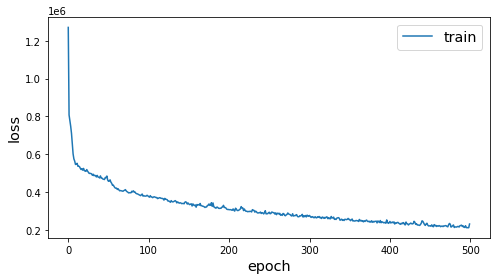

In [ ]:
%%time
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pair_model.save('/content/drive/MyDrive/THESIS - SNG/models/stellarmodel1')

In [ ]:
from tensorflow import keras
pair_model = keras.models.load_model('/content/drive/MyDrive/THESIS - SNG/models/stellarmodel1')

#Compute embeddings

In [ ]:
embeddings = embedding_model.predict(generator.flow(sgraphs))

/usr/local/lib/python3.7/dist-packages/stellargraph/mapper/padded_graph_generator.py:283: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = np.full((len(graphs), max_nodes), fill_value=False, dtype=np.bool)


In [ ]:
embeddings

array([[3.1081424e+00, 0.0000000e+00, 2.4055621e+02, ..., 3.1795925e+01,
        2.3704268e+01, 3.2536417e+02],
       [3.0045776e+00, 0.0000000e+00, 2.4611890e+02, ..., 6.9841299e+00,
        5.2722569e+01, 3.4545154e+02],
       [0.0000000e+00, 0.0000000e+00, 2.1466135e+02, ..., 0.0000000e+00,
        0.0000000e+00, 4.8378470e+02],
       ...,
       [7.5512820e-01, 0.0000000e+00, 1.9947701e+02, ..., 0.0000000e+00,
        2.0758547e+01, 5.4608954e+02],
       [3.1430943e+01, 0.0000000e+00, 2.0659598e+02, ..., 3.9497360e+02,
        9.3946333e+00, 1.9494775e+02],
       [4.3133861e-01, 0.0000000e+00, 2.1086639e+02, ..., 0.0000000e+00,
        0.0000000e+00, 6.0104259e+01]], dtype=float32)

# K-means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import kelbow_visualizer
scaler = StandardScaler()

In [ ]:
#scale all the values
X= scaler.fit_transform(embeddings)

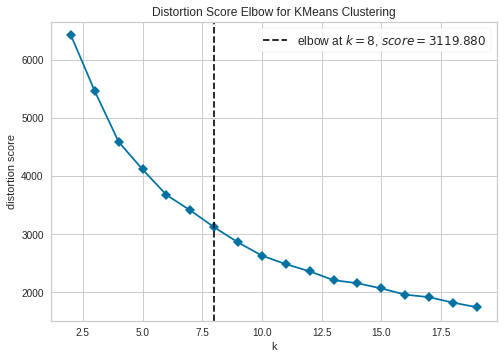

AttributeError: ignored

TypeError: ignored

In [ ]:
# we see in how many groups our data can be clustered
kelbow_visualizer(KMeans(random_state=4), X, k=(2,20), timings=False)

In [ ]:
#initialize the kmeans model
kmeans = KMeans(n_clusters=10, random_state=42 ,algorithm="elkan").fit(X)

In [ ]:
#run the model on our data
y_kmeans = kmeans.predict(X)

In [ ]:
# Labels for each row
labels= kmeans.labels_
print(labels)

[0 0 9 2 0 5 5 5 9 8 9 5 0 9 0 3 9 1 5 9 1 1 1 1 0 5 3 0 1 7 7 1 8 5 5 9 1
 3 9 5 5 5 1 7 0 9 1 1 0 9 3 5 0 0 5 4 8 2 5 8 9 5 0 8 5 6 9 0 3 5 4 5 4 3
 0 1 0 3 8 5 0 4 3 3 0 3 0 0 8 8 3 9 3 7 1 0 9 5 0 5 8 0 0 3 5 3 3 0 2 8]


#Load images

In [ ]:
import cv2
import os
import glob
from google.colab.patches import cv2_imshow

def load_images_from_folder(folder):
    images = []
    filenames = glob.glob(os.path.join(folder,"*"))
    for i in range(0,len(filenames)):
      img = cv2.imread(os.path.join(folder,'{}.png'.format(i)))
      if img is not None:
        #img = cv2.resize(img, (150, 150))   
        images.append(img)
    return images

In [ ]:
images = load_images_from_folder('/city plots')
len(images)

110

In [ ]:
#for 10 clusters - 300m radius
for i in range(0,9):
  print('label           == {}'.format(i))
  result = np.where(labels == i)
  resimg = [images[i] for i in result[0]]
  for img in resimg:
    cv2_imshow(img)

#Visualize embeddings

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
two_d_scaled = StandardScaler().fit_transform(two_d)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_scatter_with_images(X_2d_data, images, figsize=(100,100), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()


In [ ]:
visualize_scatter_with_images(two_d_scaled, images, image_zoom=0.6)

Output hidden; open in https://colab.research.google.com to view.